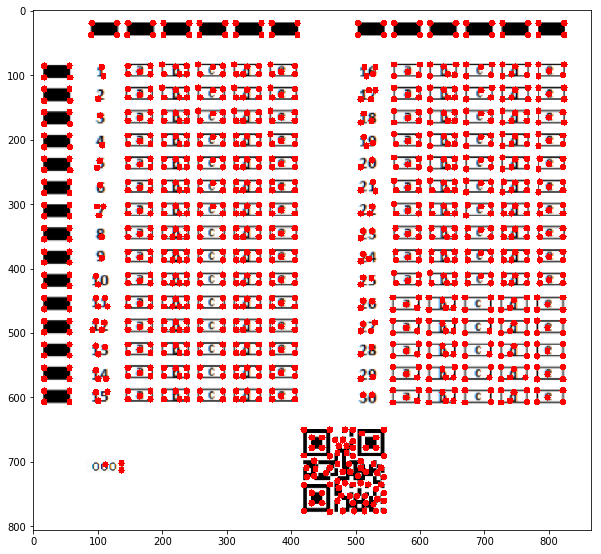

In [35]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img  = cv2.imread('data/pattern_0001.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 2500, 0.2, 10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img, (x,y), 5, 255, -1)

plt.imshow(img)
plt.show()